In [112]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymysql

from functools import reduce
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

cm = sns.light_palette("green", as_cmap=True)


In [2]:
# MySQL Connection 연결
conn = pymysql.connect(host='localhost', user='root', password='root', db='dashboard_cafe24', charset='utf8')

# Connection 으로부터 Cursor 생성
curs = conn.cursor(pymysql.cursors.DictCursor)

In [3]:
sql = '''select date, sum(페이지뷰), sum(전체방문수), sum(순방문수), sum(처음방문수), sum(재방문수),
        sum(구매자수), sum(처음방문구매건수), sum(재방문구매건수), 
        sum(재방문구매건수), sum(처음구매상품수), sum(재구매상품수), 
        sum(처음구매액), sum(재구매액), sum(처음방문구매액) , sum(재방문구매액)
from data_hour group by date order by date desc'''
curs.execute(sql)
rows = curs.fetchall()
df = pd.DataFrame(rows)



In [4]:
df

,date,sum(페이지뷰),sum(전체방문수),sum(순방문수),sum(처음방문수),sum(재방문수),sum(구매자수),sum(처음방문구매건수),sum(재방문구매건수),.sum(재방문구매건수),sum(처음구매상품수),sum(재구매상품수),sum(처음구매액),sum(재구매액),sum(처음방문구매액),sum(재방문구매액)
0,2020-05-23,4171,1256,1077,552,560,8,1,6,6,25,0,227960,0,26920,188430
1,2020-05-22,10264,2879,2622,1268,1611,28,9,19,19,42,1,437740,16400,132010,322130
2,2020-05-21,6293,1403,1228,573,830,21,9,12,12,42,8,347720,96400,200220,243900
3,2020-05-20,7777,1874,1681,781,1093,41,16,25,25,74,14,853040,132560,328910,656690
4,2020-05-19,7953,2349,2167,1059,1290,30,9,21,21,57,3,704260,38200,218140,524320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-02-28,17992,5774,5376,3323,2451,34,10,24,24,110,0,877520,0,211800,665720
86,2020-02-27,10818,3161,2949,1813,1348,19,6,13,13,76,0,520600,0,142800,377800
87,2020-02-26,6959,2235,2059,1327,908,15,9,6,6,47,0,365420,0,198780,166640
88,2020-02-25,5228,1757,1638,1056,701,9,4,5,5,23,3,182000,23700,97600,108100


# 검색앤진별 매출액

In [5]:
# SQL문 실행
sql = "select * from data_day_searchengine"
curs.execute(sql)
rows = curs.fetchall()

In [6]:
df = pd.DataFrame(rows)
pdf1 = df.pivot_table(index="date", columns="검색엔진", values='방문수' , aggfunc='sum').fillna(0).sort_index(ascending=False)
pdf2 = df.pivot_table(index="date", columns="검색엔진", values='구매건수' , aggfunc='sum').fillna(0).sort_index(ascending=False)
pdf3 = df.pivot_table(index="date", columns="검색엔진", values='매출액' , aggfunc='sum').fillna(0).sort_index(ascending=False)

pdf1.index = pd.to_datetime(pdf1.index)
pdf2.index = pd.to_datetime(pdf2.index)
pdf3.index = pd.to_datetime(pdf3.index)



In [7]:
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
tab = widgets.Tab(children = [out1, out2, out3])
tab.set_title(0, '방문수')
tab.set_title(1, '구매건수')
tab.set_title(2, '매출액')
display(tab)

with out1:
    #plt.show(pdf1)
    display(pdf1.style.background_gradient(cmap=cm))

with out2:
    #plt.show(pdf2)a
    display(pdf2.style.background_gradient(cmap=cm))
    
with out3:
    #plt.show(pdf3)
    display(pdf3.style.background_gradient(cmap=cm))
    
    
plt.figure(figsize=(20, 5))
sns.lineplot(data=pdf1, palette="tab10", linewidth=2.5)

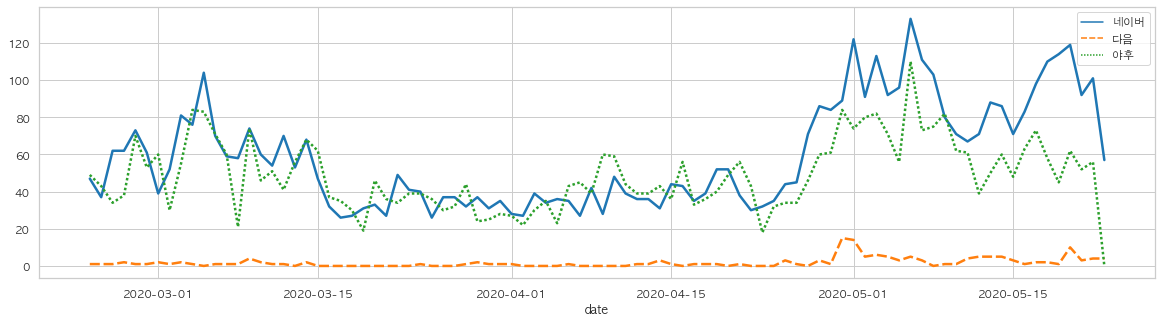

In [9]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=pdf1[['네이버','다음','야후']], palette="tab10", linewidth=2.5)

# 상품의 주차별 판매건수

In [167]:
# SQL문 실행
sql = "select * from data_day_cateogry_product"
curs.execute(sql)
rows = curs.fetchall()

In [173]:
df = pd.DataFrame(rows)
df = df[~df['category'].isin(['SALE','NEW','BEST','Curation1','collection1','기획전1', '메인화면', 'Shop All'])]
df['date'] = pd.to_datetime(df['date'])
df['weekofyear'] = df['date'].dt.weekofyear

In [178]:
row_li = []
for item in df['상품명'].unique():
    sub = df[df['상품명'] == item]
    
    data = {}
    for week in sub.weekofyear.unique():
        ssub = sub[sub['weekofyear'] == week]
        uc = len(set(ssub['category']))
        data[week] = uc
    data['상품명'] = item
    row_li.append(data)
    
tmp = pd.DataFrame(row_li).fillna(0)
tmp.index = tmp['상품명']
tmp = tmp.drop(columns=['상품명'])
tmp.style.background_gradient(cmap=cm,axis=0)

# 컬렉션의 주차별 시각화

In [181]:
df.pivot_table(columns='weekofyear', index='category', values='노출수', aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)


weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
category,,,,,,,,,,,,,
Artist Edition,0,25,33,19,54,13,41,17,31,191,132,24,13
Best,1,9,133,103,84,131,138,163,182,553,412,153,49
New,1,6,22,54,210,193,309,78,97,335,323,102,54
One Point Series,0,0,0,0,0,0,0,0,0,0,0,0,53
Postcard Edition,0,0,0,0,0,0,0,0,0,0,0,5,82
Realism,0,0,0,0,0,0,0,0,2,5,8,5,9
Sale,0,10,66,6,8,1,23,41,27,10,44,39,14
Spring Collection,2,1,4,1,44,2,0,0,0,0,0,12,31


In [182]:
df.pivot_table(columns='weekofyear', index='category', values='담긴수', aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)


weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
category,,,,,,,,,,,,,
Artist Edition,0,59,100,40,54,23,55,60,101,254,253,57,19
Best,1,25,94,47,53,61,62,67,140,277,221,185,242
New,8,44,90,107,234,135,110,126,244,502,435,257,315
One Point Series,0,0,0,0,0,0,0,0,0,0,0,0,54
Postcard Edition,0,0,0,0,0,0,0,0,0,0,0,11,44
Realism,0,0,0,0,0,0,0,0,10,16,28,22,27
Sale,0,344,382,45,32,10,116,251,256,86,156,40,43
Spring Collection,2,6,9,8,45,4,0,0,0,0,0,8,22


In [183]:
df.pivot_table(columns='weekofyear', index='category', values='판매건수', aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)


weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
category,,,,,,,,,,,,,
Artist Edition,0,13,11,8,12,3,18,20,36,59,70,12,3
Best,0,9,18,10,15,12,18,14,49,87,81,51,64
New,3,10,17,32,65,29,24,31,53,131,126,58,87
One Point Series,0,0,0,0,0,0,0,0,0,0,0,0,11
Postcard Edition,0,0,0,0,0,0,0,0,0,0,0,5,12
Realism,0,0,0,0,0,0,0,0,3,2,12,10,5
Sale,0,25,27,4,3,2,30,70,68,18,44,9,13
Spring Collection,1,3,1,1,8,0,0,0,0,0,0,2,6


In [184]:
df.pivot_table(columns='weekofyear', index='category', values='판매물품수', aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)


weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
category,,,,,,,,,,,,,
Artist Edition,0,13,11,8,13,4,18,22,37,60,71,12,3
Best,0,9,18,10,16,12,19,16,50,89,89,53,65
New,3,11,17,33,73,34,26,31,55,135,136,60,95
One Point Series,0,0,0,0,0,0,0,0,0,0,0,0,11
Postcard Edition,0,0,0,0,0,0,0,0,0,0,0,5,13
Realism,0,0,0,0,0,0,0,0,3,2,13,10,5
Sale,0,72,68,4,3,2,32,72,73,18,47,9,15
Spring Collection,2,3,1,1,8,0,0,0,0,0,0,2,8


In [185]:
(df.pivot_table(columns='weekofyear', index='category', values='판매금액', aggfunc='sum').\
fillna(0) / 1000 ).style.background_gradient(cmap=cm) 

weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
category,,,,,,,,,,,,,
Artist Edition,0,166.7,158.4,111.2,180.7,66.6,261.2,311.3,514.3,839.5,1003.4,183.3,41.7
Best,0,93.1,216.2,118.5,162.4,126.8,206.1,172.4,537,887.1,947.1,578.7,729.5
New,31.7,118.9,154.3,330.7,732.7,336.6,273.4,308.9,562.5,1374.5,1354.4,1920.5,1696.2
One Point Series,0,0,0,0,0,0,0,0,0,0,0,0,62.9
Postcard Edition,0,0,0,0,0,0,0,0,0,0,0,205.4,158
Realism,0,0,0,0,0,0,0,0,41.7,27.8,180.7,127,51.5
Sale,0,846.8,814.2,49.6,45.2,31.3,320.8,822.8,792.7,170.2,495.3,111.1,184.5
Spring Collection,39.8,50.7,11.9,19.4,91.2,0,0,0,0,0,0,15.8,83.2


In [186]:
tmp = df[df['category'] == 'New']
(tmp.pivot_table(columns='weekofyear', index='상품명', values='판매금액', aggfunc='sum').\
fillna(0) / 1000 ).style.background_gradient(cmap=cm) 

weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
상품명,,,,,,,,,,,,,
PPP,0,0,0,0,0,0,0,0,0,0,0,0,0
굿 바이브 온리,0,0,0,0,0,0,0,0,0,0,0,0,4.9
나이트 웨이브,0,0,0,0,0,0,0,0,0,0,0,0,5.9
노스텔직 나이트,0,0,0,7.9,0,0,0,0,0,0,0,0,0
단델리온,0,0,0,0,0,0,0,0,0,0,0,0,0
데이지,0,0,0,31.6,94.8,23.7,7.9,39.5,47.4,165.9,134.3,0,0
라비앙로즈,0,0,0,0,0,0,0,0,0,0,0,39.5,55.3
라인 버터플라이,0,0,0,0,0,0,0,0,0,0,0,0,5.9
러브 레터,0,0,0,0,0,0,0,0,0,0,0,0,11.8


In [187]:
tmp = df[df['category'] == 'Best']
(tmp.pivot_table(columns='weekofyear', index='상품명', values='판매금액', aggfunc='sum').\
fillna(0) / 1000 ).style.background_gradient(cmap=cm) 

weekofyear,9,10,11,12,13,14,15,16,17,18,19,20,21
상품명,,,,,,,,,,,,,
가든 파티,0,0,0,11.9,0,35.7,23.8,23.8,0,0,0,83.3,11.9
노스텔직 나이트,0,0,0,0,0,0,0,0,7.9,55.3,39.5,31.6,31.6
데이 드림,0,0,47.6,23.8,47.6,23.8,35.7,71.4,166.6,130.9,226.1,23.8,83.3
데이지,0,0,0,0,0,0,0,0,0,0,0,15.8,0
라비앙로즈,0,0,0,0,0,0,0,0,0,0,0,0,15.8
러브 드렁크,0,0,0,0,0,0,0,0,0,0,0,0,0
러브 이즈 본,0,13.9,27.8,0,0,0,13.9,0,0,0,0,0,0
로만 할리데이,0,0,0,0,0,0,0,0,0,0,0,35.7,35.7
마이 리틀 유니버스,0,23.7,15.8,0,47.4,23.7,55.3,15.8,79,213.3,55.3,0,39.5


In [188]:
tmp = df[df['category'] == 'Sale']
(tmp.pivot_table(columns='weekofyear', index='상품명', values='판매금액', aggfunc='sum').\
fillna(0) / 1000 ).style.background_gradient(cmap=cm) 

weekofyear,10,11,12,13,14,15,16,17,18,19,20,21
상품명,,,,,,,,,,,,
PPP,0,0,0,0,0,0,0,0,0,0,0,13.9
가든 파티,0,0,0,0,0,0,119,11.9,0,0,0,0
굿 뉴스,0,0,0,0,0,11.9,0,23.8,0,11.9,0,0
나이트 칠,0,0,0,0,0,0,11.9,0,0,0,0,0
나이트메어,0,0,0,19.4,19.4,0,0,0,0,0,0,0
네버 마인드,0,0,0,0,0,0,0,0,0,0,0,0
노 조크,11.9,11.9,11.9,0,0,0,0,0,0,0,0,11.9
노스텔직 나이트,0,0,0,0,0,71.1,47.4,102.7,71.1,110.6,0,0
다니엘 시저,0,0,0,0,0,0,0,0,0,0,0,0
